In [1]:
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format='retina'

# Description
This notebook shows extraction of computation of ccy-collateralized-in-EUR curves from knowing xccy spreads when **direct ccy vs EUR xccy quotes are NOT available**.

For example, if only USD-CZK, USD-EUR quotes are available, we are interested in CZK-collateralized-in-EUR curve for which we need to use the intermediary USD currency.

# Example 1: Computation of CZK-collateralized-in-EUR via USD xccy spreads
Scenario: we have:
- USD vs EUR-20bp xccy quotes,
- USD vs CZK+50bp xccy quotes,

both collateralized in EUR.

**TASK**: We are searching for CZK-collateralized-in-EUR curve.

This gives us challenges because we don't have a direct trade EUR CZK but we have an itermediary currency USD.

The computation of CZK-collateralized-in-EUR curve thus invoves two steps:
- computation of USD-collateralized-in-EUR curve from the USD vs EUR-20bp xccy quotes trades
- knowing the USD-collateralized-in-EUR curve, computation of CZK-collateralized-in-EUR curve from the USD vs CZK+50bp xccy quotes.


Additionally, since we obtain the CZK-collateralized-in-EUR in the second step, we use it to build direct CZK+x vs EUR spread quotes. 
Then we use these quotes to retrieve the CZK-collateralized-in-EUR curve from these direct CZK+x vs EUR spreads.

In [2]:
date = ql.Date(18,8,2022)
ql.Settings.instance().evaluationDate = date

eur_rate = 0.01   # flat zero continuously compounded rate obtained from €STR OIS curve
usd_rate = 0.015  # flat zero continuously compounded rate obtained from SOFR OIS curve
czk_rate = 0.03   # flat zero continuously compounded rate obtained from CZK  OIS curve

eur_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(eur_rate)),ql.SimpleDayCounter()))
usd_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(usd_rate)),ql.SimpleDayCounter()))
czk_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(czk_rate)),ql.SimpleDayCounter()))



## Computation of `USD-collateralized-in-EUR` curve

In [3]:
baseCurrencyIndex  = ql.Estr(eur_curve) # for forecasting EUR-leg cash-flow
quoteCurrencyIndex = ql.Sofr(usd_curve) # for forecasting USD-leg cash-flow

helpers_xccy = []
for tenor, eur_spread in [('1Y', -0.002),('5Y', -0.002),('10Y', -0.002)]:
    basis  = ql.QuoteHandle(ql.SimpleQuote(eur_spread))
    helper = ql.CrossCurrencyBasisSwapRateHelper(basis, 
                                                 ql.Period(tenor), 0, 
                                                 ql.NullCalendar(), 
                                                 ql.ModifiedFollowing, True,
                                                 baseCurrencyIndex, 
                                                 quoteCurrencyIndex, 
                                                 eur_curve, True, True)
    helpers_xccy.append(helper)

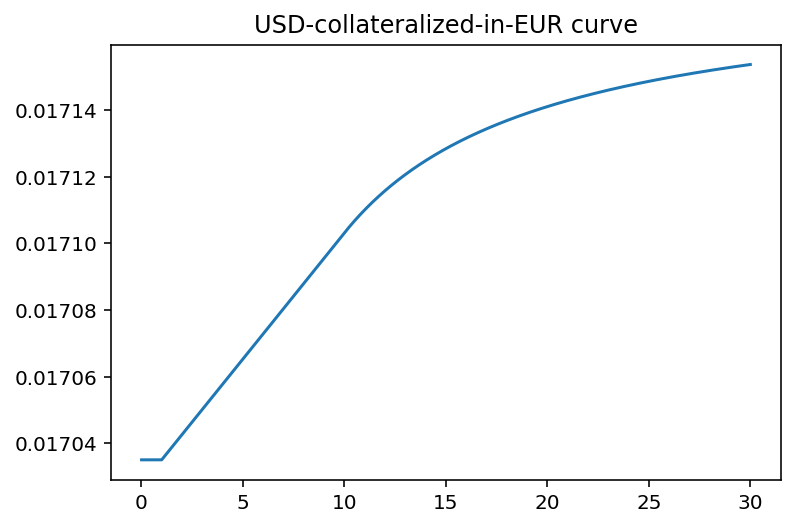

In [4]:
mod_usd_curve = ql.PiecewiseLinearZero(0,ql.NullCalendar(),
                                            helpers_xccy,
                                            ql.SimpleDayCounter())
mod_usd_curve.enableExtrapolation()

times = np.linspace(0.01, 30, 1000)
mod_usd_rates = [mod_usd_curve.zeroRate(t, ql.Continuous).rate() for t in times]

plt.plot(times, mod_usd_rates);
plt.title('USD-collateralized-in-EUR curve');

## Computation of `CZK-collateralized-in-EUR` curve from USD-CZK xccy trades

The main trick here is that although USD-CZK trade is _NOT_ collateralized in USD (but in EUR), we pass in the `ql.CrossCurrencyBasisSwapRateHelper` the USD-collateralized-in-EUR curve (`ql.YieldTermStructureHandle(mod_usd_curve)`) as the curve of the collateral. 

Thus we call:
```python
    ql.CrossCurrencyBasisSwapRateHelper(basis, 
                                        tenor, 
                                        fixingDays, 
                                        calendar, 
                                        convention, 
                                        endOfMonth, 
                                        baseCurrencyIndex, 
                                        quoteCurrencyIndex, 
                                        collateralCurve = ql.YieldTermStructureHandle(mod_usd_curve), # we use USD-collateralized-in-EUR as collateral curve the USD leg 
                                        isFxBaseCurrencyCollateralCurrency = True, # True because the USD leg is in fact the leg with which the collateral curve associates
                                        isBasisOnFxBaseCurrencyLeg = False) # basis is on CZK (which is NOT the base currency leg)
```
This makes the `QuantLib` algorithm believe we know the collateralization of the base currency leg (USD)

In [5]:
baseCurrencyIndex  = ql.Sofr(usd_curve) # for forecasting USD-leg cash-flow
quoteCurrencyIndex = ql.Estr(czk_curve) # for forecasting CZK-leg cash-flow

helpers_xccy = []
for tenor, eur_spread in [('1Y', 0.005),('5Y', 0.005),('10Y', 0.005)]:
    basis  = ql.QuoteHandle(ql.SimpleQuote(eur_spread))
    helper = ql.CrossCurrencyBasisSwapRateHelper(basis, 
                                                 ql.Period(tenor), 0, 
                                                 ql.NullCalendar(), 
                                                 ql.ModifiedFollowing, True,
                                                 baseCurrencyIndex, 
                                                 quoteCurrencyIndex, 
                                                 ql.YieldTermStructureHandle(mod_usd_curve), True, False)
    helpers_xccy.append(helper)

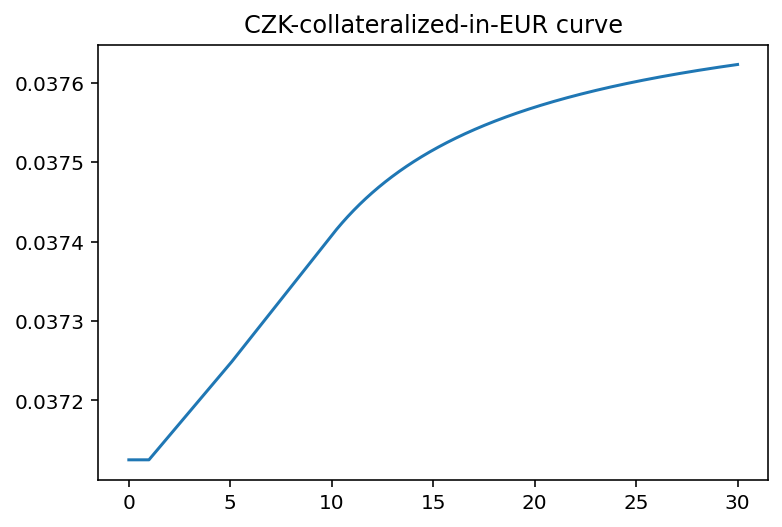

In [6]:
mod_czk_curve = ql.PiecewiseLinearZero(0,ql.NullCalendar(),
                                            helpers_xccy,
                                            ql.SimpleDayCounter())
mod_czk_curve.enableExtrapolation()

times = np.linspace(0.01, 30, 1000)
mod_czk_rates = [mod_czk_curve.zeroRate(t, ql.Continuous).rate() for t in times]

plt.plot(times, mod_czk_rates);
plt.title('CZK-collateralized-in-EUR curve');

## Helper xccy fair spread bootstrapping object
The idea behind this xccy helper object is that if we know all curves for 2 ccies, it allows us to back out the fair spread on one of the legs.

In [7]:
class xccy_swap:

    def __init__(self, pricing_date: ql.Date, index_curve_leg_A, index_curve_leg_B, tenor_years, spread_legA = 0.0, spread_legB = 0.0):

        self.inputs = locals()
        self.inputs.pop('self');

        self.schedule    = ql.MakeSchedule(pricing_date, ql.NullCalendar().advance(pricing_date, ql.Period(tenor_years, ql.Years)), ql.Period('1Y'))
        

    def build_swap(self, pricing_date: ql.Date, index_curve_leg_A, index_curve_leg_B, tenor_years, spread_legA, spread_legB):
        
        legA     = ql.OvernightLeg([1], self.schedule, index_curve_leg_A, ql.SimpleDayCounter(), ql.Following, [1], [spread_legA], True)
        legB     = ql.OvernightLeg([1], self.schedule, index_curve_leg_B, ql.SimpleDayCounter(), ql.Following, [1], [spread_legB], True)
        self.legA = legA
        self.legB = legB

        self.legA_notional = ql.Leg([ql.SimpleCashFlow(1.0, max(self.schedule))])
        self.legB_notional = ql.Leg([ql.SimpleCashFlow(1.0, max(self.schedule))])

    def npv(self, legA_discount_curve, legB_discount_curve):
        pricing_date = self.inputs['pricing_date']

        self.build_swap(**self.inputs)
        legA_npv = ql.CashFlows.npv(self.legA, legA_discount_curve, True, pricing_date) + ql.CashFlows.npv(self.legA_notional, legA_discount_curve, True, pricing_date)
        legB_npv = ql.CashFlows.npv(self.legB, legB_discount_curve, True, pricing_date) + ql.CashFlows.npv(self.legB_notional, legB_discount_curve, True, pricing_date)

        return legA_npv - legB_npv

    def fair_spread(self, legA_discount_curve, legB_discount_curve, searchSpreadOnLegA = True):
        from scipy.optimize import root_scalar
        inputs = self.inputs
        inputs.pop('spread_legA');
        inputs.pop('spread_legB');

        if searchSpreadOnLegA:
            return root_scalar(lambda spread: xccy_swap(**inputs, spread_legB = 0.0, spread_legA = spread).npv(legA_discount_curve, legB_discount_curve), x0 = -0.1 ,x1 = 0.1).root
        else:
            return root_scalar(lambda spread: xccy_swap(**inputs, spread_legA = 0.0, spread_legB = spread).npv(legA_discount_curve, legB_discount_curve), x0 = -0.1 ,x1 = 0.1).root

## Iteratively compute xccy spreads from known `ccy-collateralized-in-EUR` curves

In [8]:
swap = xccy_swap(pricing_date = date, 
                index_curve_leg_A = ql.Estr(eur_curve), 
                index_curve_leg_B = ql.Sofr(usd_curve), 
                tenor_years = 10)

swap.fair_spread(eur_curve, ql.YieldTermStructureHandle(mod_usd_curve), True)

#here we check that the correct EUR+x vs USD xccy spread is x=-20bp 

-0.0020598879195287234

In [9]:
# compute the spread x in EUR vs x+CZK xccy trades, given we derived above the CZK-collateralized-in-EUR curve

swap = xccy_swap(pricing_date = date, index_curve_leg_A = ql.Estr(eur_curve), index_curve_leg_B = ql.Estr(czk_curve), tenor_years = 1)
spread1y = swap.fair_spread(eur_curve, ql.YieldTermStructureHandle(mod_czk_curve), False)

swap = xccy_swap(pricing_date = date, index_curve_leg_A = ql.Estr(eur_curve), index_curve_leg_B = ql.Estr(czk_curve), tenor_years = 5)
spread5y = swap.fair_spread(eur_curve, ql.YieldTermStructureHandle(mod_czk_curve), False)

swap = xccy_swap(pricing_date = date, index_curve_leg_A = ql.Estr(eur_curve), index_curve_leg_B = ql.Estr(czk_curve), tenor_years = 10)
spread10y = swap.fair_spread(eur_curve, ql.YieldTermStructureHandle(mod_czk_curve), False)

print(f'Fair spread x in 1Y  EUR vs x+CZK xccy trade is x={spread1y}')
print(f'Fair spread x in 5Y  EUR vs x+CZK xccy trade is x={spread5y}')
print(f'Fair spread x in 10Y EUR vs x+CZK xccy trade is x={spread10y}')

Fair spread x in 1Y  EUR vs x+CZK xccy trade is x=0.00736854507963635
Fair spread x in 5Y  EUR vs x+CZK xccy trade is x=0.007500423640035056
Fair spread x in 10Y EUR vs x+CZK xccy trade is x=0.007660748984182727


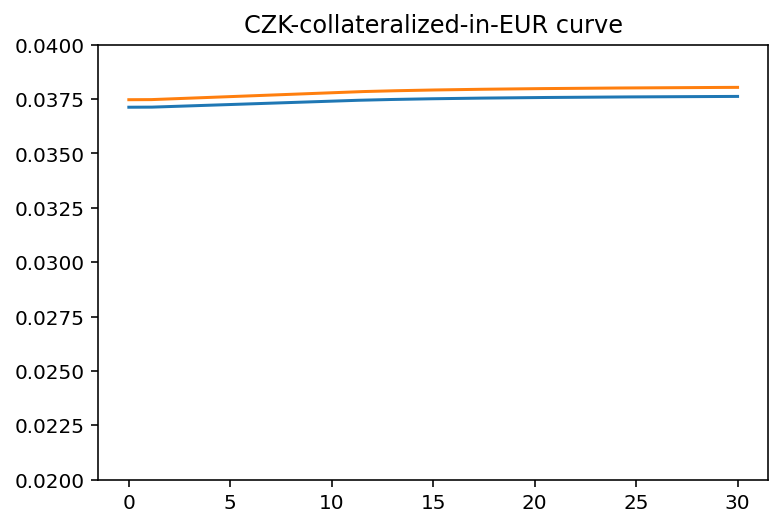

In [10]:
# Verify that if we used these EUR vs CZK xccy spreads directly (instead of using USD), we would get the CZK-collateralized-in-EUR curve as in pic above.
baseCurrencyIndex  = ql.Estr(eur_curve) # for forecasting EUR-leg cash-flow
quoteCurrencyIndex = ql.Estr(czk_curve) # for forecasting CZK-leg cash-flow

helpers_xccy = []
for tenor, czk_spread in [('1Y', 0.00736854507963635),('5Y', 0.007500423640035056),('10Y', 0.007660748984182727)]:
    basis  = ql.QuoteHandle(ql.SimpleQuote(czk_spread))
    helper = ql.CrossCurrencyBasisSwapRateHelper(basis, 
                                                 ql.Period(tenor), 0, 
                                                 ql.NullCalendar(), 
                                                 ql.ModifiedFollowing, True,
                                                 baseCurrencyIndex, 
                                                 quoteCurrencyIndex, 
                                                 eur_curve, True, False)
    helpers_xccy.append(helper)

mod_czk_curve = ql.PiecewiseLinearZero(0,ql.NullCalendar(),
                                            helpers_xccy,
                                            ql.SimpleDayCounter())
mod_czk_curve.enableExtrapolation()

times = np.linspace(0.01, 30, 1000)
mod_czk_rates2 = [mod_czk_curve.zeroRate(t, ql.Continuous).rate() for t in times]

fig, ax = plt.subplots()
ax.plot(times, mod_czk_rates);
ax.plot(times, mod_czk_rates2);
ax.set_title('CZK-collateralized-in-EUR curve');
ax.set_ylim([0.02, 0.04]);

# => we can see that the approximately -75bp spreads on the CZK leg against EUR almost identically reproduces the CZK-in-EUR discount curve 
# relative to the case where we used first EUR-USD and then USD-CZK trades to obtain CZK-collateralized-in-EUR curve


# Example 2: knowing the modified in-EUR-col curves ahead
In this part we pretend that instead of knowing the spreads, know ahead:
- USD-collateralized-in-EUR curve,
- GBP-collateralized-in-EUR curve.

Then, we will build xccy spreads wich are _true_ (observed) spreads as they have been built off these known modified curves. 

Then we take from these _true_ spreads only (USD vs x+GBP) and (EUR+x vs USD) as being given, and use them to bootstrap:
- USD-collateralized-in-EUR curve,
- GBP-collateralized-in-EUR curve, 

and from these we try to reconstruct the _tue_ GBP+x vs EUR spreads.


In [11]:
date = ql.Date(18,8,2022)
ql.Settings.instance().evaluationDate = date

eur_rate     = 0.01   # flat zero continuously compounded rate obtained from €STR  OIS curve
usd_rate     = 0.015  # flat zero continuously compounded rate obtained from SOFR  OIS curve
gbp_rate     = 0.03   # flat zero continuously compounded rate obtained from SONIA OIS curve
usd_rate_mod = 0.018  # we assume to know the mod USD curve (collateralized in EUR)
gbp_rate_mod = 0.035  # we assume to know the mod GBP curve (collateralized in EUR)

eur_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(eur_rate)),ql.SimpleDayCounter()))
usd_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(usd_rate)),ql.SimpleDayCounter()))
gbp_curve = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(gbp_rate)),ql.SimpleDayCounter()))

usd_curve_mod = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(usd_rate_mod)),ql.SimpleDayCounter()))
gbp_curve_mod = ql.YieldTermStructureHandle(ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(gbp_rate_mod)),ql.SimpleDayCounter()))

tenors = [1, 3, 5, 10, 15, 20, 30]

spread_eur_eurusd = []
spread_gbp_gbpusd = []
spread_gbp_gbpeur = []
for tenor in tenors:
    spread_eur_eurusd.append(xccy_swap(date, ql.Estr(eur_curve),  ql.Sofr(usd_curve), tenor).fair_spread(eur_curve,     usd_curve_mod, True))
    spread_gbp_gbpusd.append(xccy_swap(date, ql.Sonia(gbp_curve), ql.Sofr(usd_curve), tenor).fair_spread(gbp_curve_mod, usd_curve_mod, True))
    spread_gbp_gbpeur.append(xccy_swap(date, ql.Sonia(gbp_curve), ql.Estr(eur_curve), tenor).fair_spread(gbp_curve_mod, eur_curve, True))

spreads = pd.DataFrame({'EUR+x vs USD': spread_eur_eurusd, 'GBP+x vs USD':spread_gbp_gbpusd, 'GBP+x vs EUR':spread_gbp_gbpeur})
spreads['tenor'] = tenors
spreads


,EUR+x vs USD,GBP+x vs USD,GBP+x vs EUR,tenor
0,-0.003026,0.002063,0.005165,1
1,-0.003006,0.002024,0.005183,3
2,-0.002981,0.001967,0.005176,5
3,-0.002926,0.001843,0.005185,10
4,-0.002871,0.001714,0.005184,15
5,-0.002819,0.001587,0.005185,20
6,-0.002721,0.001338,0.005183,30


## Build `USD-collateralized-in-EUR` curve from known spreads

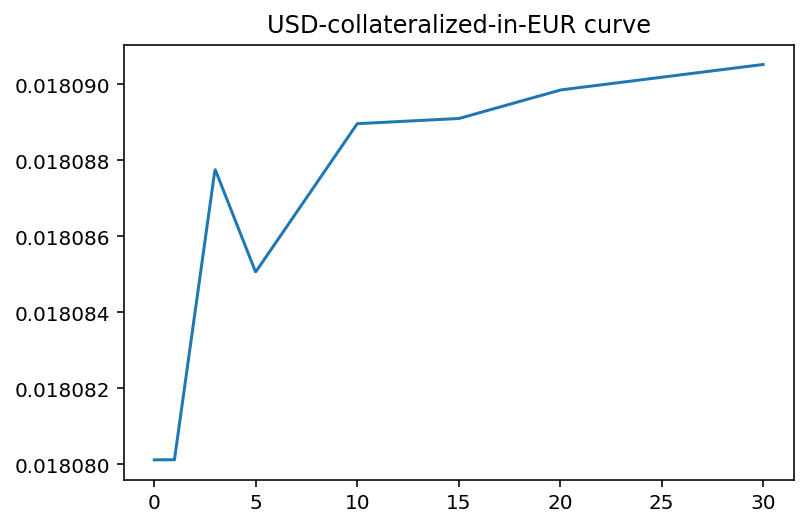

In [12]:
# build modified USD curve (USD-collateralized-in-EUR) from USD vs x+EUR quotes above
helpers_xccy = []
for tenor, eur_spread in spreads[['tenor', 'EUR+x vs USD']].values:
    helper = ql.CrossCurrencyBasisSwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(eur_spread)), 
                                                 ql.Period(int(tenor), ql.Years), 0, 
                                                 ql.NullCalendar(), 
                                                 ql.ModifiedFollowing, True,
                                                 ql.Estr(eur_curve), 
                                                 ql.Sofr(usd_curve), 
                                                 eur_curve, True, True)
    helpers_xccy.append(helper)

usd_curve_mod = ql.PiecewiseLinearZero(0,ql.NullCalendar(),
                                             helpers_xccy,
                                             ql.SimpleDayCounter())
usd_curve_mod = ql.YieldTermStructureHandle(usd_curve_mod)
times = np.linspace(0.01, 30, 1000)
plt.plot(times, [usd_curve_mod.zeroRate(t, ql.Continuous).rate() for t in times]);
plt.title('USD-collateralized-in-EUR curve');

## Build `GBP-collateralized-in-EUR` curve from known spreads

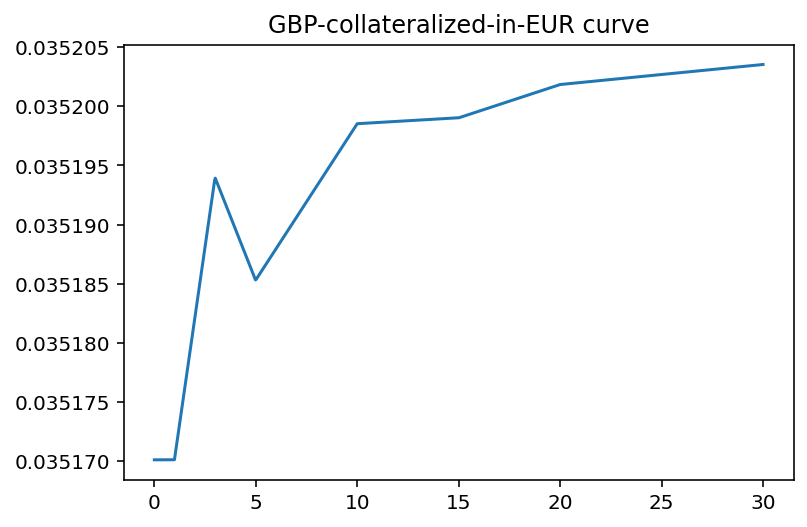

In [13]:
# build modified GBP curve (GBP-collateralized-in-EUR) from GBP+x vs USD quotes above
helpers_xccy = []
for tenor, gbp_spread in spreads[['tenor', 'GBP+x vs USD']].values:
    helper = ql.CrossCurrencyBasisSwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(gbp_spread)), 
                                                 ql.Period(int(tenor), ql.Years), 0, 
                                                 ql.NullCalendar(), 
                                                 ql.ModifiedFollowing, True,
                                                 ql.Sonia(gbp_curve), 
                                                 ql.Sofr(usd_curve), 
                                                 usd_curve_mod, False, True)
    helpers_xccy.append(helper)

gbp_curve_mod = ql.PiecewiseLinearZero(0,ql.NullCalendar(),
                                             helpers_xccy,
                                             ql.SimpleDayCounter())

gbp_curve_mod = ql.YieldTermStructureHandle(gbp_curve_mod)

times = np.linspace(0.01, 30, 1000)
plt.plot(times, [gbp_curve_mod.zeroRate(t, ql.Continuous).rate() for t in times]);
plt.title('GBP-collateralized-in-EUR curve');

## Compute the GBP+x vs EUR spreads

In [14]:
# compute the GBP+x vs EUR spreads given computed GBP-collateralized-in-EUR curve, compare with 'true' spreads above
spread_gbp_gbpeur = []
for tenor in tenors:
    spread_gbp_gbpeur.append(xccy_swap(date, ql.Sonia(gbp_curve), ql.Estr(eur_curve), tenor).fair_spread(gbp_curve_mod, eur_curve, True))

print('compare results:')
print('computed spreads x+GBP vs EUR:', spread_gbp_gbpeur)
print("'true' spreads x+GBP vs EUR:", spreads['GBP+x vs EUR'].to_list())

# => indeed we observe negligible differences

compare results:
computed spreads x+GBP vs EUR: [0.00534135003724205, 0.005383380914681481, 0.005368330354805004, 0.0053893779478978035, 0.005389557674675529, 0.005392633342297395, 0.005391865305861478]
'true' spreads x+GBP vs EUR: [0.005165174846106283, 0.005183069653662728, 0.005176285101409717, 0.005185086398466203, 0.005184491461774421, 0.005185204249833981, 0.005182922002682443]
